# Basic Network

## 1. Two coplanar circular orbits

In the following section we will focus on a toy model of our problem : two coplanar circular orbits, one LEO and one MEO orbit.
The following algorithms are constructed as descripted in the *Multi-orbit routing and scheduling paper.*


In [1]:
#Import packages

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

In [2]:
#Define useful constants

mu = 398600     #Earth’s gravitational parameter in [km³∕s²]
T = 86400      #setting the time horizon [s]
dT = 900    #setting the discretization step of our time horizon [s]

We begin with implementing a useful set of classes for our objects  later on

A faire : créer une database imitant la structure de Table 1 dans le papier, afin de garder une trace de :
 - L'orbite à laquelle appartient chaque noeud
 - La période et l'espacement des noeuds

In [3]:
class Orbit :
    def __init__(self,
                 id: int,
                 orbital_period: float,
                 time_unit_duration: int
                 ) :
        self.id = id
        self.Torb = orbital_period
        self.dt = time_unit_duration*dT
        self.r = ((mu * orbital_period**2)/(4*np.pi**2))**(1/3)
    def __str__(self) -> str:
        return f"Orbit {self.id}"
    
class Node :
    def __init__(self,
                 id: int,
                 orbit: Orbit,
                 true_anomaly: float
                 ) :
        self.id = id
        self.orbit = orbit
        self.theta = true_anomaly
    def __str__(self) :
        return f"Node {self.id}"
    
    def get_arcs(self,net) :
        N_arc = [arc for arc in net.arcs if arc.start_node == self]
        return N_arc
    
    def orbital_arc(self,
                    net
                    ) :
        N_arc = self.get_arcs(net)
        orbit_arc = [arc for arc in N_arc if arc.type == 'Orbital_maneuver']
        return orbit_arc[0]
    

class Arc :
    def __init__(self,
                 start_node: Node,
                 end_node: Node,
                 type: str,
                 tho: float,
                 phi: float
                 ) :
        self.start_node = start_node
        self.end_node = end_node
        self.type = type
        self.tho = tho
        self.phi = phi
    def __str__(self) -> str:
        return f"({self.start_node},{self.end_node},{self.type})"
    
class Network :
    def __init__(self,
                nodes: list[Node],
                arcs: list[Arc]
                ) -> None:
        self.nodes = nodes
        self.arcs = arcs
    # def __str__(self):
    #         nodes_str = '\n'.join(str(node) for node in self.nodes)
    #         arcs_str = '\n'.join(str(arc) for arc in self.arcs)
    #         return f"Nœuds:\n{nodes_str}\nArcs:\n{arcs_str}"
    def __str__(self) -> str:
        return f"{np.size(self.nodes)} Nodes and {np.size(self.arcs)} Arcs"
    

    def draw_curved_arrow(self, 
                          start_node: Node, 
                          end_node: Node, 
                          arc_type: str
                          ):
        
        #Warning : the angle theta is an orbital angle in the clockwise direction, so we have to use -theta for the trigonometric direction
        start_x = start_node.orbit.r * np.cos(-start_node.theta*np.pi/180)
        start_y = start_node.orbit.r * np.sin(-start_node.theta*np.pi/180)
        end_x = end_node.orbit.r * np.cos(-end_node.theta*np.pi/180)
        end_y = end_node.orbit.r * np.sin(-end_node.theta*np.pi/180)


        # Calculate the midpoint and distance between nodes
        mid_x = (start_x + end_x) / 2
        mid_y = (start_y + end_y) / 2
        distance = np.sqrt((end_x - start_x) ** 2 + (end_y - start_y) ** 2)

        # Fixed displacement for the curve, calculating the angle alpha compared to the horizontal

        displacement = distance/10 * np.sqrt(np.sin(np.linspace(0,np.pi,100)))
        alpha = math.atan2((end_y-start_y),(end_x-start_x))

        curve_x = np.linspace(start_x, end_x, 100) - displacement * np.sin(alpha)
        curve_y = np.linspace(start_y, end_y, 100) + displacement * np.cos(alpha)

        ctype = {'Orbital_maneuver' : 'blue',
                 'Phasing_maneuver' : 'green',
                 'Hohmann_transfer' : 'red',
                 'sink_node' : 'gray'}

        # Plotting the curve
        plt.plot(curve_x, curve_y, linewidth=1, color = ctype[arc_type])

        # Add an arrow at the end
        arrow = FancyArrowPatch((curve_x[-1], curve_y[-1]), 
                                (end_x, end_y), 
                                arrowstyle='->', 
                                color='blue', 
                                mutation_scale=10)
        plt.gca().add_patch(arrow)
    
    def visualize(self, arc_types_to_display):
        plt.figure(figsize=(8, 8))
        ax = plt.gca()

        # Plot nodes
        for node in self.nodes:
            x = node.orbit.r * np.cos(-node.theta*np.pi/180)
            y = node.orbit.r * np.sin(-node.theta*np.pi/180)
            if node.id == 0 :
                plt.plot(x, y, 'o', markersize=8, color = 'red')
            else :
                plt.plot(x, y, 'o', markersize=8, color = 'black')


        # Plot arcs based on types

        for arc in self.arcs:
            if arc.type in arc_types_to_display:
                self.draw_curved_arrow(arc.start_node,arc.end_node,arc.type)

        plt.xlim(-max(node.orbit.r for node in self.nodes) - 1, max(node.orbit.r for node in self.nodes) + 1)
        plt.ylim(-max(node.orbit.r for node in self.nodes) - 1, max(node.orbit.r for node in self.nodes) + 1)
        plt.axhline(0, color='black',linewidth=0.5, ls='--')
        plt.axvline(0, color='black',linewidth=0.5, ls='--')
        plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title("Network Visualization")
        plt.show()

Then we are going to define functions to create the orbital maneuvers needed for the problem. Since we consider two coplanar orbits, we do not have to implement the Hohmann transfer with inclination change maneuver.

In [4]:
def orbital_maneuver(N1: Node,
                     N2: Node
                     ) :
    dtheta = (N2.theta - N1.theta)%360
    time_duration = dtheta/360 * N1.orbit.Torb
    return Arc(start_node=N1,end_node=N2,type='Orbital_maneuver',tho=time_duration,phi=0)
    

def phasing_maneuver(N1: Node, 
                     N2: Node, 
                     k=1
                     ):
    # Calcul du changement d'anomalie vraie (en radians)
    theta_i = N1.theta
    theta_j = N2.theta

    if theta_j - theta_i < 0:
        delta_phi = (360 + (theta_j - theta_i)) * (math.pi / 180)
    else:
        delta_phi = (theta_j - theta_i) * (math.pi / 180)

    # Mouvement moyen
    n = math.sqrt(mu / N1.orbit.r**3)

    # Période de l'ellipse de phasage
    T_phasing_ellipse = (2 * k * math.pi + delta_phi) / (k * n)

    # Demi-grand axe de l'ellipse de phasage
    a_phasing_ellipse = ((mu * T_phasing_ellipse**2) / (4 * math.pi**2)) ** (1/3)

    # Changement de vitesse total
    delta_V = 2 * abs(
        math.sqrt(2 * mu / N1.orbit.r - mu / a_phasing_ellipse) - 
        math.sqrt(mu / N1.orbit.r)
    )

    # Temps pour compléter la manœuvre de phasage
    t_delta_phi = T_phasing_ellipse * (delta_phi / (2 * math.pi)) + k * T_phasing_ellipse

    return Arc(N1,N2,'Phasing_maneuver',t_delta_phi,delta_V)


def hohmann_transfer(N1: Node,
                     N2: Node
                     ):
    
    r1 = N1.orbit.r
    r2 = N2.orbit.r
    # Calcul du moment angulaire pour l'orbite de départ
    h1 = math.sqrt(mu * r1)  
    # Calcul du moment angulaire pour l'orbite de transfert
    h2 = math.sqrt(2 * mu * (r1 * r2 / (r1 + r2)))  
    # Calcul du moment angulaire pour l'orbite de destination
    h3 = math.sqrt(mu * r2)  

    # Vitesse à l'orbite de départ
    V1 = h1/r1
    # Vitesse à l'orbite de transfert
    V2 = h2/r1
    # Vitesse à l'orbite de destination
    V3 = h3/r2

    # Changement de vitesse pour la manœuvre
    delta_v1 = V2 - V1 
    delta_v2 = V3 - V2
    delta_V = abs(delta_v1) + abs(delta_v2)

    # Temps pour la manœuvre
    T = (2 * math.pi * (r2 ** 3/2) ) / math.sqrt(mu)

    return Arc(N1,N2,'Hohmann_transfer',T,delta_V)



Let's create our Network!

In [5]:
def node_creation(O: list[Orbit],
                  ) :
    N = []
    id = 0
    for o in O :
        sub = o.Torb//o.dt
        theta = 0
        for k in range(sub) :
            N.append(Node(id=id,orbit=o,true_anomaly=theta))
            id+=1
            theta+= 360/sub
    return N


def arc_creation(N: list[Node]) :
    A = []
    for N1 in N :
        for N2 in N :
            if N1 != N2 :
                dtheta = (N2.theta - N1.theta)%360
                if N1.orbit == N2.orbit :   #If nodes are on the same orbit
                    sub = N1.orbit.Torb//N1.orbit.dt
                    if dtheta == 360/sub :     #if nodes are adjacent in the direction of orbit
                        A.append(orbital_maneuver(N1,N2))
                    else :  #If nodes are not adjascent in the direction of orbit
                        A.append(phasing_maneuver(N1,N2))

                elif N1.orbit != N2.orbit and (N1.theta-N2.theta)%360 == 180 :
                    A.append(hohmann_transfer(N1,N2))
    return A

def add_sink(N: list[Node],
             A: list[Arc]
             ) :
    N.append(Node(id=-1,orbit=Orbit(0,0,0),true_anomaly=0))
    for N1 in N :
        if N1.id != -1 :
            A.append(Arc(N1,N[-1],'sink_node',0,0))  


In [6]:
O1 = Orbit(id=1,orbital_period=5400,time_unit_duration=1)
O2 = Orbit(id=2,orbital_period=43200,time_unit_duration=2)
O = [O1,O2]


N = node_creation(O)
A = arc_creation(N)

add_sink(N,A)

net = Network(N,A)

print(net)

31 Nodes and 624 Arcs


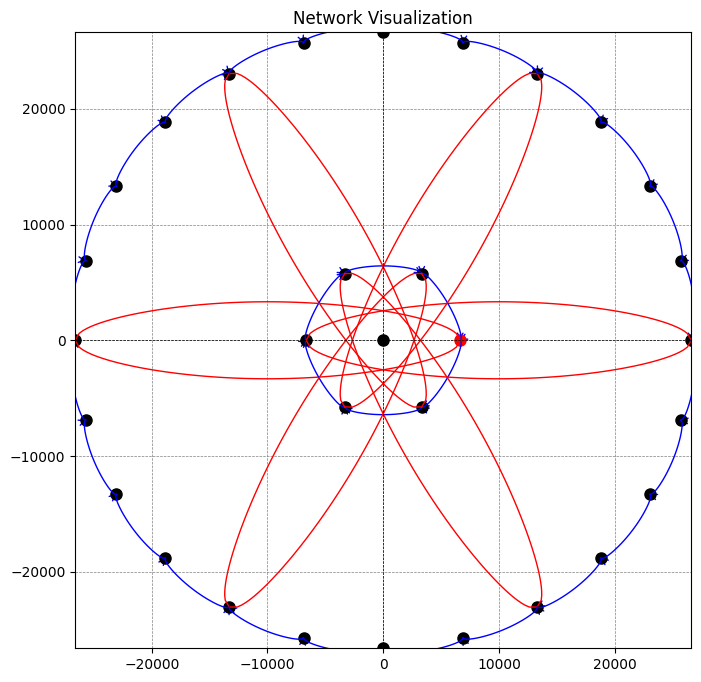

In [7]:
net.visualize(['Orbital_maneuver','Hohmann_transfer'])

# Sub-tasks creation

Now we will implement the set of tasks, subtasks, servicers and refuel depots in our network
Let's consider a set of two tasks $B = \{v_1, v_2\}$ on their respective orbits $O_1$ and $O_2$

In [8]:
class Task :
    def __init__(self,
                 id: int,
                 orbit: Orbit,
                 starting_node: Node
                 ) :
        
        assert starting_node.orbit == orbit, 'The starting node is not located on the designated orbit'
        self.id = id
        self.orbit = orbit
        self.starting_node = starting_node
    def __str__(self) -> str:
        return f"Task {self.id}"
    
    def create_subtask(self, 
                       net: Network
                       )-> tuple[Node,float] :
        Bv = []
        current_node = self.starting_node
        current_time = 0
        while current_time <= T :
            Bv.append((current_node,current_time))
            orbital_arc = current_node.orbital_arc(net)
            next_node, transfer_time = orbital_arc.end_node, orbital_arc.tho
            current_time += transfer_time
            current_node = next_node
        return Bv
    

class Servicer :
    def __init__(self,
                 id: int,
                 starting_node: Node,
                 starting_arc: Arc,
                 fuel_capacity: float
                 ) -> None:
        assert starting_arc in starting_node.get_arcs(net), 'the starting arc is not possible from the starting node'
        self.id = id
        self.starting_node = starting_node
        self.starting_arc= starting_arc
        self.F = fuel_capacity
        self.ft = fuel_capacity
        self.current_node = starting_node

    def __str__(self) -> str:
        return f'Servicer {self.id} with fuel capacity {self.F}'

In [37]:
def subtasks(B: list[Task],
             net: Network
             ) :
    """
        Returns a dictionnary assigning a set of subtasks Bv to a task v
    """
    S = {}
    # Beta = {}
    for v in B :
        Bv = v.create_subtask(net)
        S[v.id] = Bv

        # Beta[f'v'] = np.zeros(len(Bv))

    max_len = max(len(valeurs) for valeurs in S.values())
    S_padded = {k: valeurs + [None] * (max_len - len(valeurs)) for k, valeurs in S.items()}

    return S_padded

In [38]:
v1 = Task(id=1,orbit=O1,starting_node = net.nodes[0])
v2 = Task(id=2,orbit=O2,starting_node = net.nodes[10])

B = [v1,v2]

S = subtasks(B,net)


d = Servicer(id=1,starting_node=net.nodes[0],starting_arc=net.nodes[0].get_arcs(net)[0],fuel_capacity=100)
D = [d]

In [39]:
print(len(S[2]))

97


# Optimisation

L'objectif est maintenant de réaliser l'optimisation du modèle avec Julia. Pour cela, il faut enregistrer le réseau précédemment créé en format csd, afin de pouvoir utiliser cette base de donnée lors de l'optimisation.
Pour cela, nous avons besoin des données suivantes :
 - 𝑇 ∶ Set of time periods, where |𝑇| is the last time period
 - 𝑁 ∶ Set of nodes ,𝑖 ∈ 𝑁
 - 𝐸 ∶ Super sink node, 𝐸 ∈ 𝑁
 - 𝐵 ∶ Set of tasks,𝑣 ∈ 𝐵
 <!-- - 𝛤 ∶ Set of refueling depots,𝑟 ∈ 𝛤 -->
 - 𝐵𝑣 ∶ Set of sub tasks associated with 𝑣 ∈ 𝐵,𝑘 ∈ 𝐵𝑣
 - 𝐴 ∶ Set of directed arcs,(𝑖,𝑗) ∈ 𝐴
 <!-- - 𝐴𝑅𝑡 ∶ Set of refueling arcs at time 𝑡 ∈ 𝑇,𝐴𝑅𝑡 ⊂ 𝐴 -->
 - 𝐷 ∶ Set of robot servicers,𝑑 ∈ 𝐷
 - 𝑠𝑑 ∶ Starting node of servicer 𝑑 ∈ 𝐷
 - 𝐹𝑑 ∶ Maximum fuel capacity of servicer 𝑑 ∈ 𝐷, in 𝛥𝑉
 <!-- - 𝑅𝐹𝑑 ∶ The number of time periods for servicer 𝑑 to completely refuel to fuel level 𝐹𝑑, for 𝑑 ∈ 𝐷 -->
 <!-- - 𝑤𝑣 ∶ Weight of task 𝑣 ∈ 𝐵 -->
 - 𝑛𝑣𝑘 ∶ The node location of sub task 𝑘 ∈ 𝐵𝑣 of task 𝑣 ∈ 𝐵
 - 𝑡𝑣𝑘 ∶ Time period of sub task 𝑘 ∈ 𝐵𝑣 of task 𝑣 ∈ 𝐵
 - 𝜏𝑖𝑗 ∶ Time periods to traverse arc (𝑖,𝑗) ∈ 𝐴
 - 𝜙𝑖𝑗 ∶ Fuel to traverse arc (𝑖,𝑗) ∈ 𝐴, in 𝛥𝑉
 - 𝛹𝑖𝑗 ∶ Per time period fuel needed to traverse arc (𝑖,𝑗) ∈ 𝐴, in 𝛥𝑉


In [47]:
Nodes = pd.DataFrame({'id': [n.id for n in net.nodes],
                  'orbit': [n.orbit for n in net.nodes],
                  'true_anomaly': [n.theta for n in net.nodes]})


Arcs = pd.DataFrame({'start_node': [a.start_node for a in net.arcs],
                     'end_node': [a.end_node for a in net.arcs],
                     'type': [a.type for a in net.arcs],
                     'tho': [a.tho for a in net.arcs],
                     'phi': [a.phi for a in net.arcs]})

Tasks = pd.DataFrame({'id': [v.id for v in B],
                      'orbit': [v.orbit for v in B],
                      'starting_node': [v.starting_node for v in B]})

Subtasks = pd.DataFrame(S)

Servicers = pd.DataFrame({'id': [d.id for d in D],
                          'starting_node': [d.starting_node for d in D],
                          'starting_arc': [d.starting_arc for d in D],
                          'fuel_capacity': [d.F for d in D]})

data_path = './data'

Nodes.to_csv(f'{data_path}/nodes.csv')
Arcs.to_csv(f'{data_path}/arcs.csv')
Tasks.to_csv(f'{data_path}/tasks.csv')
Subtasks.to_csv(f'{data_path}/subtasks.csv')
Servicers.to_csv(f'{data_path}/servicers.csv')

In [43]:
print(Servicers)

   id starting_node                      starting_arc  fuel_capacity
0   1        Node 0  (Node 0,Node 1,Orbital_maneuver)            100


The following model has more a general approach of defining the orbits and subdivisions, which we are not going to explore for now

In [97]:
# class Orbital_param_circ :
#     def __init__(self,
#                  orbit_id: int,
#                  semi_major_axis: float,
#                  true_anomaly: float
#                  ) :
#         self.orbit_id = orbit_id
#         self.r = semi_major_axis
#         self.theta = true_anomaly
#         if semi_major_axis > 0 :
#             self.Torb = (2*np.pi*semi_major_axis)/np.sqrt(mu/semi_major_axis)
#         else :
#             self.Torb=0

# class Node :
#     def __init__(self,
#                  id: int,
#                  orbital_param: Orbital_param_circ
#                  ) :
#         self.id = id
#         self.param = orbital_param

# class Task :
#     def __init__(self,
#                  id: int,
#                  time_unit_duration: int,
#                  orbital_param: Orbital_param_circ
#                  ) :
#         self.id = id
#         self.dt = time_unit_duration*dT

#         # if (orbital_param.Torb//time_duration) > 0 :
#         #     self.dt = orbital_param.Torb/(orbital_param.Torb//time_duration)  #Here we make the choice of wanting evenly spaced nodes around an orbit, and we approach the time duration of the task with the closest higher divider of the Time to orbit
#         # else : 
#         #     self.dt = np.inf

#         self.param = orbital_param

#     def angular_duration(self) :
#         return 360/(self.param.Torb/self.dt)


# class Arc :
#     def __init__(self,
#                  start: Node,
#                  end: Node,
#                  type: str
#                  ) :
#         self.start = start
#         self.end = end
#         self.type = type




**Warning:** In the following function *arc_creation*, the parameter theta is computed by dividing 360 with the number of nodes, which supposes that all nodes from one orbit are evenly distributed around the orbit! This may not be the case in reality

In [91]:
def node_creation(B: dict[Task],
                  T: float
                  ) -> list[Node] :
    """
    Inputs: 
        B: set of tasks
        T: Time horizon
    Outputs:
        N: Network of nodes
    """
    N=[]
    for v in B :
        orbit_id,r,theta,Torb = v.param.orbit_id,v.param.r, v.param.theta, v.param.Torb
        for k in range(int(Torb/v.dt)) :   #Pour chaque sous tâche, on crée un nouveau noeud
            dtheta = 360/(Torb/v.dt)
            theta+=dtheta   #Update the true anomaly theta at each node
            param = Orbital_param_circ(r,theta)
            N.append(Node(id=k,task_id=v.id,orbital_param=param))

    N.append(Node(0,Orbital_param_circ(0,0)))   #On rajoute le "sink node"
    return N


# def arc_creation(N: list[Node],T: float,dt: float) :
#     A = []
#     for N1 in N :
#         for N2 in N :
#             if N1.id != N2.id :
#                 dtheta = N2.param.theta - N1.param.theta  #theta correspond à l'angle entre les noeuds
#                 if N1.param.r == N2.param.r :   #If both nodes are on the same orbit
                    


SyntaxError: incomplete input (1712679715.py, line 24)

In [103]:
#One task Network

r = (mu * 5400**2 / (4*np.pi**2))**(1/3)

v = Task(id=1,time_unit_duration=1,orbital_param=Orbital_param_circ(orbit_id=1,semi_major_axis=r,true_anomaly=0))

B = {v}

v.param.Torb


np.float64(5399.999999999996)